In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna, warnings, random
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

plt.style.use('dark_background')
warnings.simplefilter('ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('AIDS_Classification.csv')

In [3]:
df.head(10)

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,1,0,1,0,422,477,566,324,0
1,1002,3,61,49.4424,0,0,0,90,0,1,...,1,3,0,1,0,162,218,392,564,1
2,961,3,45,88.4520,0,1,1,90,0,1,...,1,3,0,1,1,326,274,2063,1893,0
3,1166,3,47,85.2768,0,1,0,100,0,1,...,1,3,0,1,0,287,394,1590,966,0
4,1090,0,43,66.6792,0,1,0,100,0,1,...,1,3,0,0,0,504,353,870,782,0
5,1181,1,46,88.9056,0,1,1,100,0,1,...,1,3,0,1,0,235,339,860,1060,0
6,794,0,31,73.0296,0,1,0,100,0,1,...,1,3,0,0,0,244,225,708,699,1
7,957,0,41,66.2256,0,1,1,100,0,1,...,1,3,0,0,0,401,366,889,720,0
8,198,3,40,82.5552,0,1,0,90,0,1,...,1,3,1,1,1,214,107,652,131,1
9,188,0,35,78.0192,0,1,0,100,0,1,...,1,3,0,0,1,221,132,221,759,1


In [4]:
pd.DataFrame(df.isna().sum()).T.style.background_gradient(cmap='rainbow')

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,preanti,race,gender,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      2139 non-null   int64  
 1   trt       2139 non-null   int64  
 2   age       2139 non-null   int64  
 3   wtkg      2139 non-null   float64
 4   hemo      2139 non-null   int64  
 5   homo      2139 non-null   int64  
 6   drugs     2139 non-null   int64  
 7   karnof    2139 non-null   int64  
 8   oprior    2139 non-null   int64  
 9   z30       2139 non-null   int64  
 10  preanti   2139 non-null   int64  
 11  race      2139 non-null   int64  
 12  gender    2139 non-null   int64  
 13  str2      2139 non-null   int64  
 14  strat     2139 non-null   int64  
 15  symptom   2139 non-null   int64  
 16  treat     2139 non-null   int64  
 17  offtrt    2139 non-null   int64  
 18  cd40      2139 non-null   int64  
 19  cd420     2139 non-null   int64  
 20  cd80      2139 non-null   int6

In [6]:
df.describe(percentiles=[0, .25, .30, .50, .75, .80, 1]).T.style.background_gradient(cmap = 'inferno')

,count,mean,std,min,0%,25%,30%,50%,75%,80%,100%,max
time,2139.000000,879.098177,292.274324,14.000000,14.000000,727.000000,825.000000,997.000000,1091.000000,1105.000000,1231.000000,1231.000000
trt,2139.000000,1.520804,1.127890,0.000000,0.000000,1.000000,1.000000,2.000000,3.000000,3.000000,3.000000,3.000000
age,2139.000000,35.248247,8.709026,12.000000,12.000000,29.000000,30.000000,34.000000,40.000000,42.000000,70.000000,70.000000
wtkg,2139.000000,75.125311,13.263164,31.000000,31.000000,66.679200,68.200000,74.390400,82.555200,84.809280,159.939360,159.939360
hemo,2139.000000,0.084151,0.277680,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
homo,2139.000000,0.661057,0.473461,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
drugs,2139.000000,0.131370,0.337883,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
karnof,2139.000000,95.446470,5.900985,70.000000,70.000000,90.000000,90.000000,100.000000,100.000000,100.000000,100.000000,100.000000
oprior,2139.000000,0.021973,0.146629,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
z30,2139.000000,0.550257,0.497584,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
target = 'infected'
cont_cols = ['time', 'age', 'wtkg', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820']
dis_cols = list(set(df.columns) - set([*cont_cols, target]))

len(cont_cols), len(dis_cols)

(8, 14)

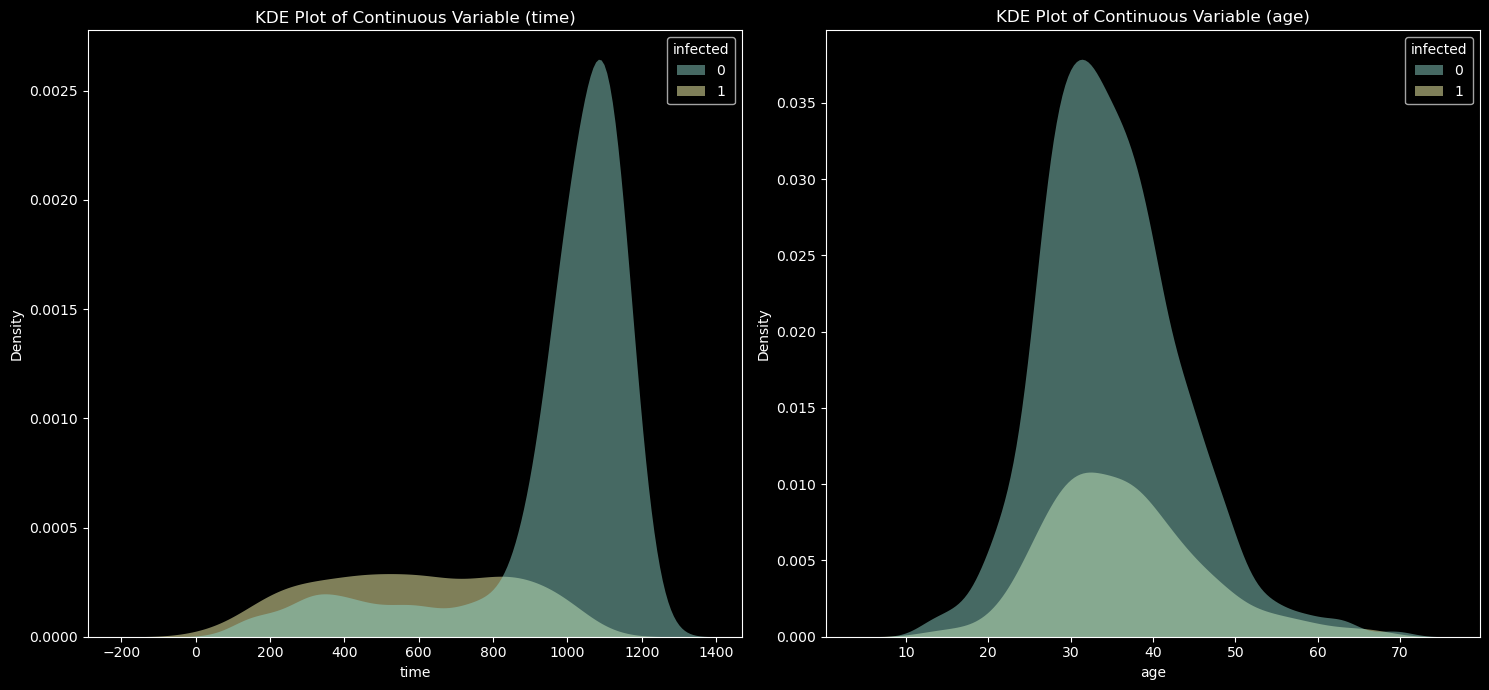

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for i, col in enumerate(['time', 'age']):
    sns.kdeplot(data=df, x=col, hue=target, alpha=.5, linewidth=0, fill=True, ax=axes[i])
    axes[i].set_title(f'KDE Plot of Continuous Variable ({col})')
    
plt.tight_layout()
plt.show()

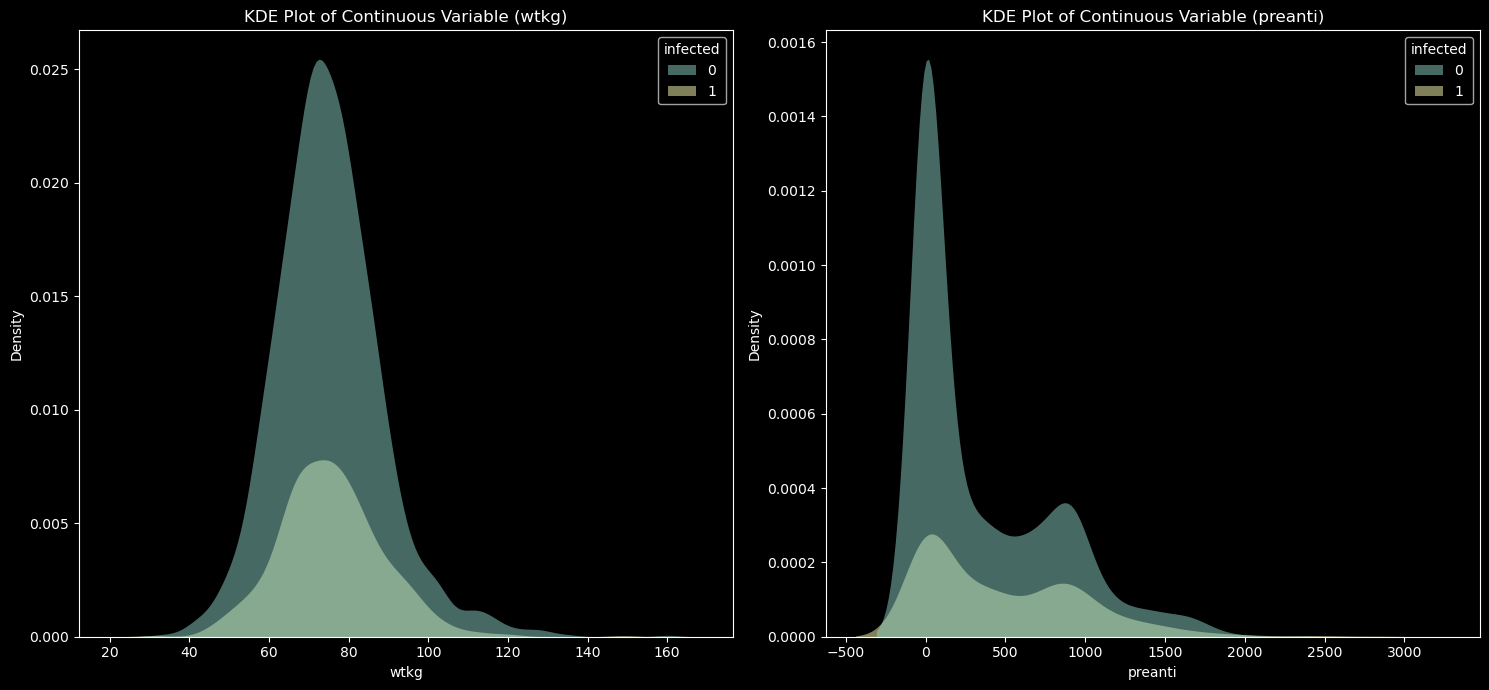

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for i, col in enumerate(['wtkg', 'preanti']):
    sns.kdeplot(data=df, x=col, hue=target, alpha=.5, linewidth=0, fill=True, ax=axes[i])
    axes[i].set_title(f'KDE Plot of Continuous Variable ({col})')
    
plt.tight_layout()
plt.show()

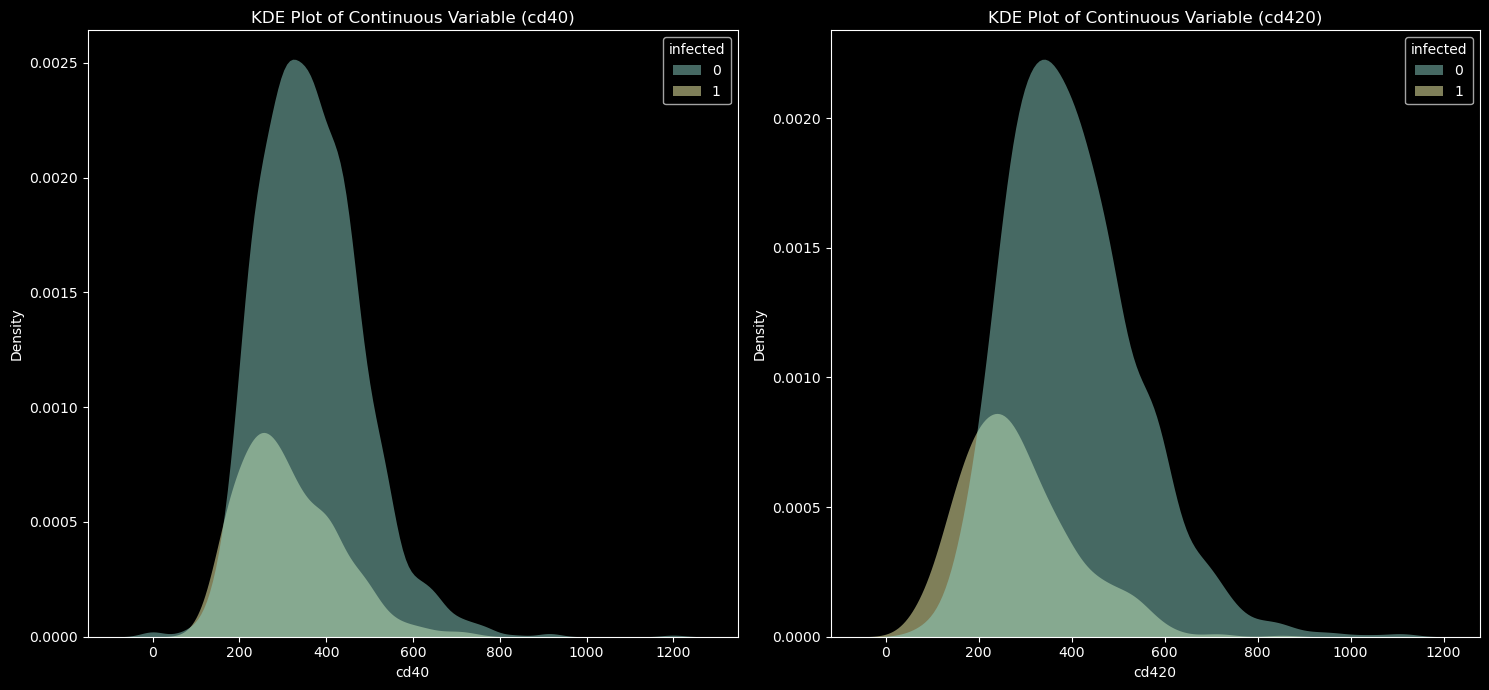

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for i, col in enumerate(['cd40', 'cd420']):
    sns.kdeplot(data=df, x=col, hue=target, alpha=.5, linewidth=0, fill=True, ax=axes[i])
    axes[i].set_title(f'KDE Plot of Continuous Variable ({col})')
    
plt.tight_layout()
plt.show()

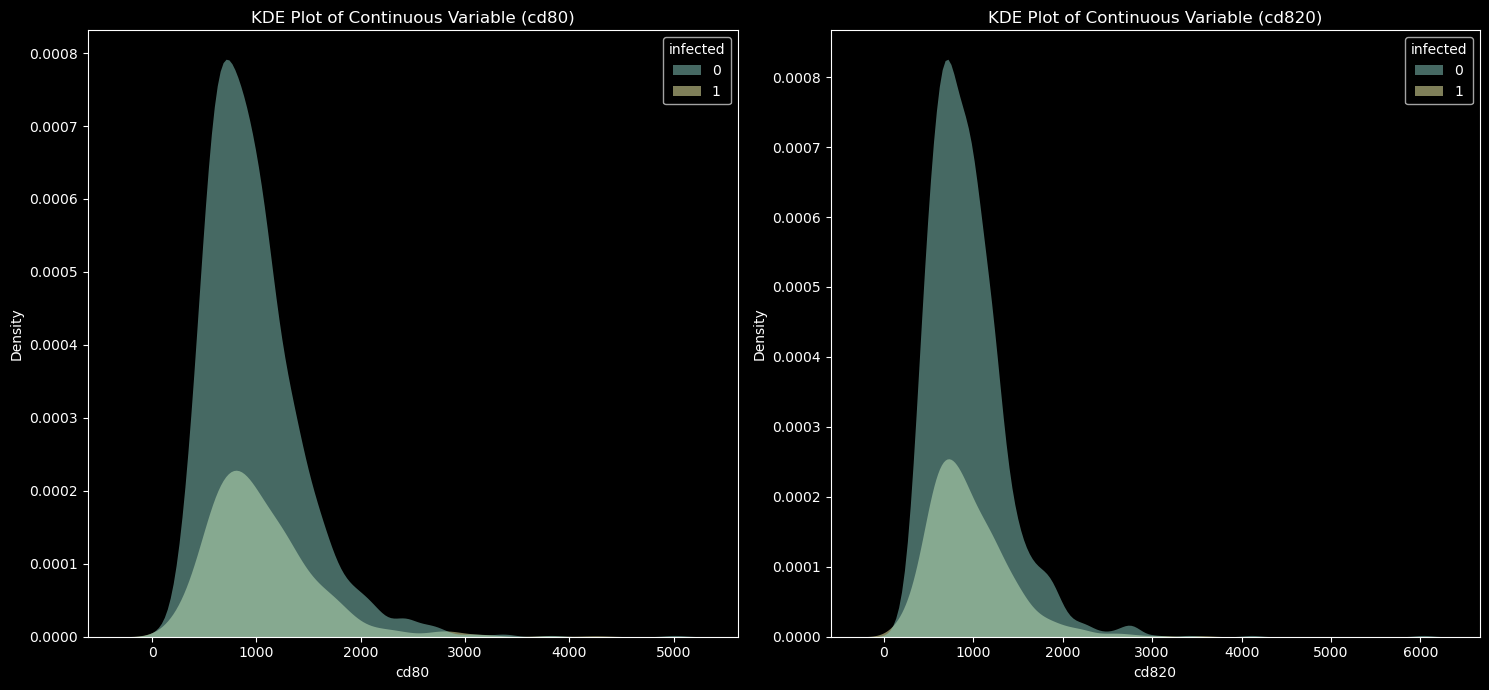

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for i, col in enumerate(['cd80', 'cd820']):
    sns.kdeplot(data=df, x=col, hue=target, alpha=.5, linewidth=0, fill=True, ax=axes[i])
    axes[i].set_title(f'KDE Plot of Continuous Variable ({col})')
    
plt.tight_layout()
plt.show()

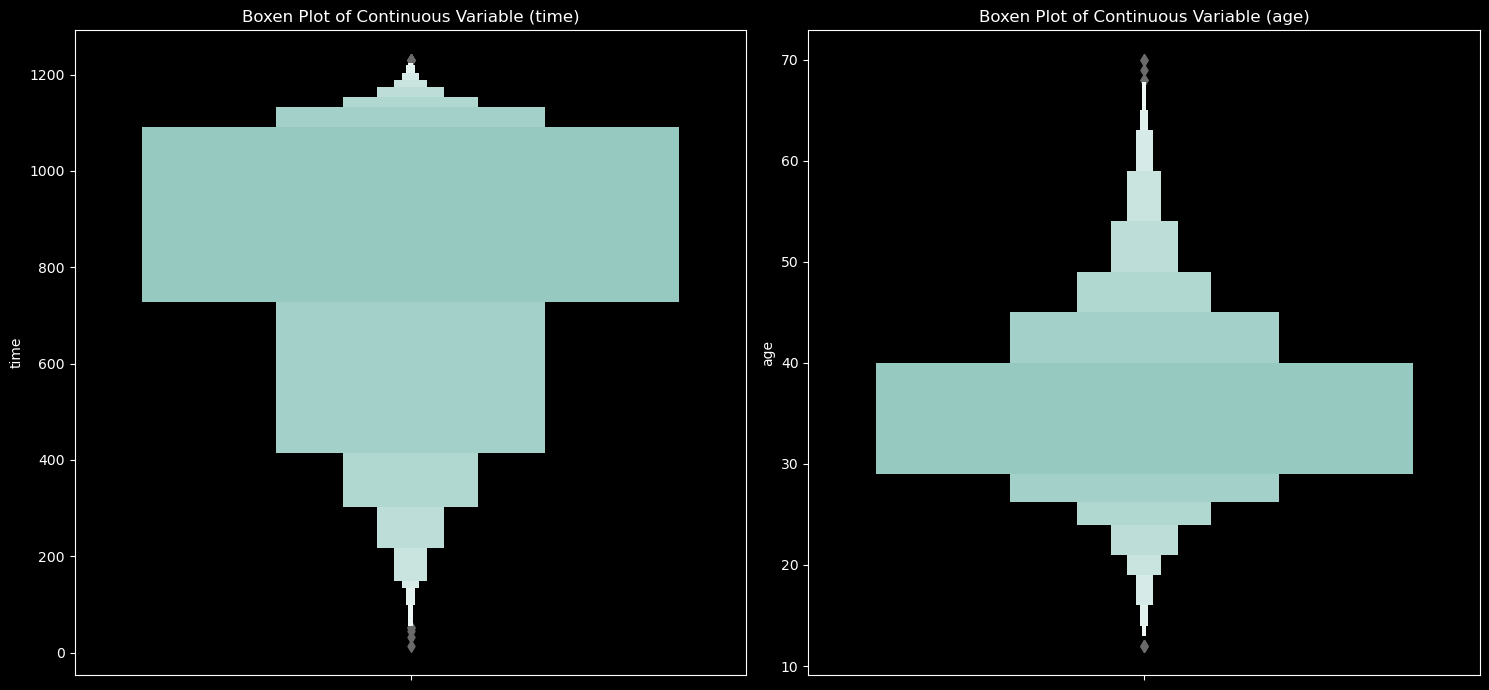

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for i, col in enumerate(['time', 'age']):
    sns.boxenplot(data=df, y=col, hue=target, linewidth=0, ax=axes[i])
    axes[i].set_title(f'Boxen Plot of Continuous Variable ({col})')
    
plt.tight_layout()
plt.show()

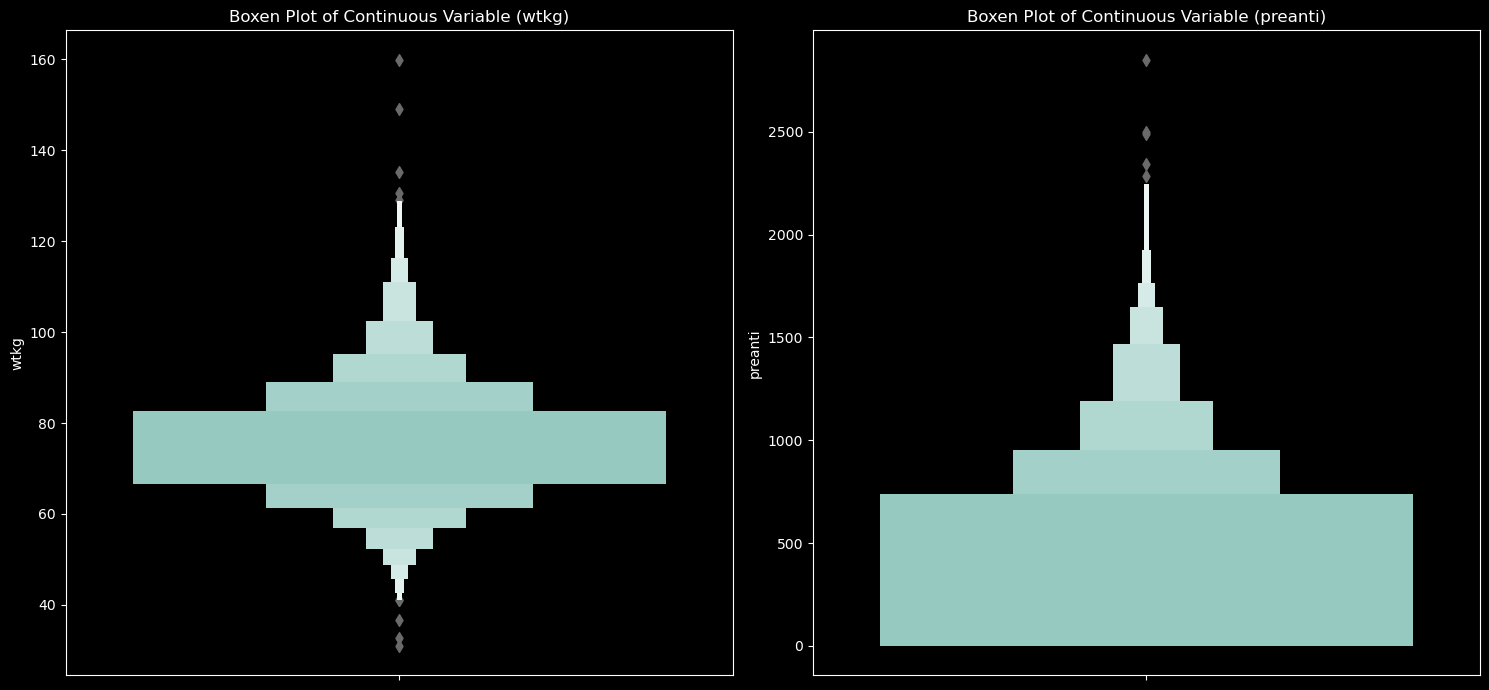

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for i, col in enumerate(['wtkg', 'preanti']):
    sns.boxenplot(data=df, y=col, hue=target, linewidth=0, ax=axes[i])
    axes[i].set_title(f'Boxen Plot of Continuous Variable ({col})')
    
plt.tight_layout()
plt.show()

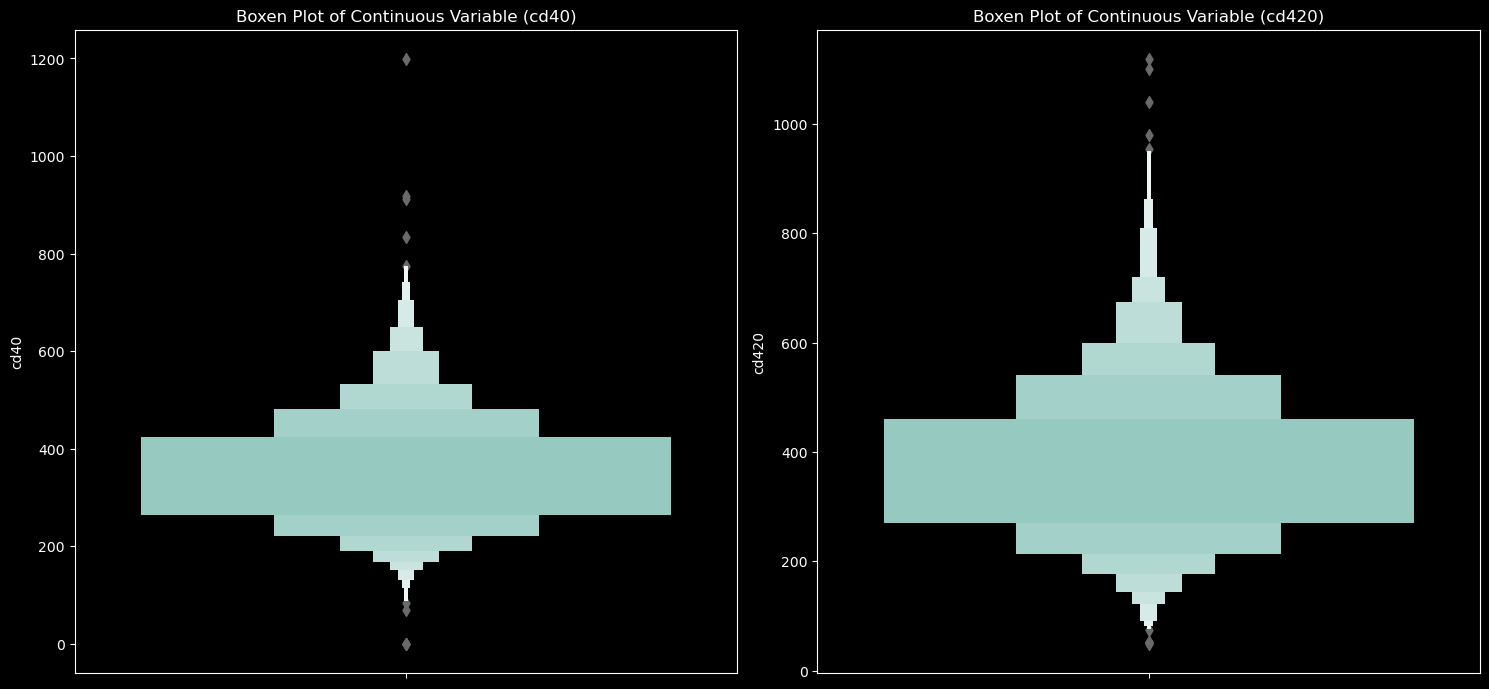

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for i, col in enumerate(['cd40', 'cd420']):
    sns.boxenplot(data=df, y=col, hue=target, linewidth=0, ax=axes[i])
    axes[i].set_title(f'Boxen Plot of Continuous Variable ({col})')
    
plt.tight_layout()
plt.show()

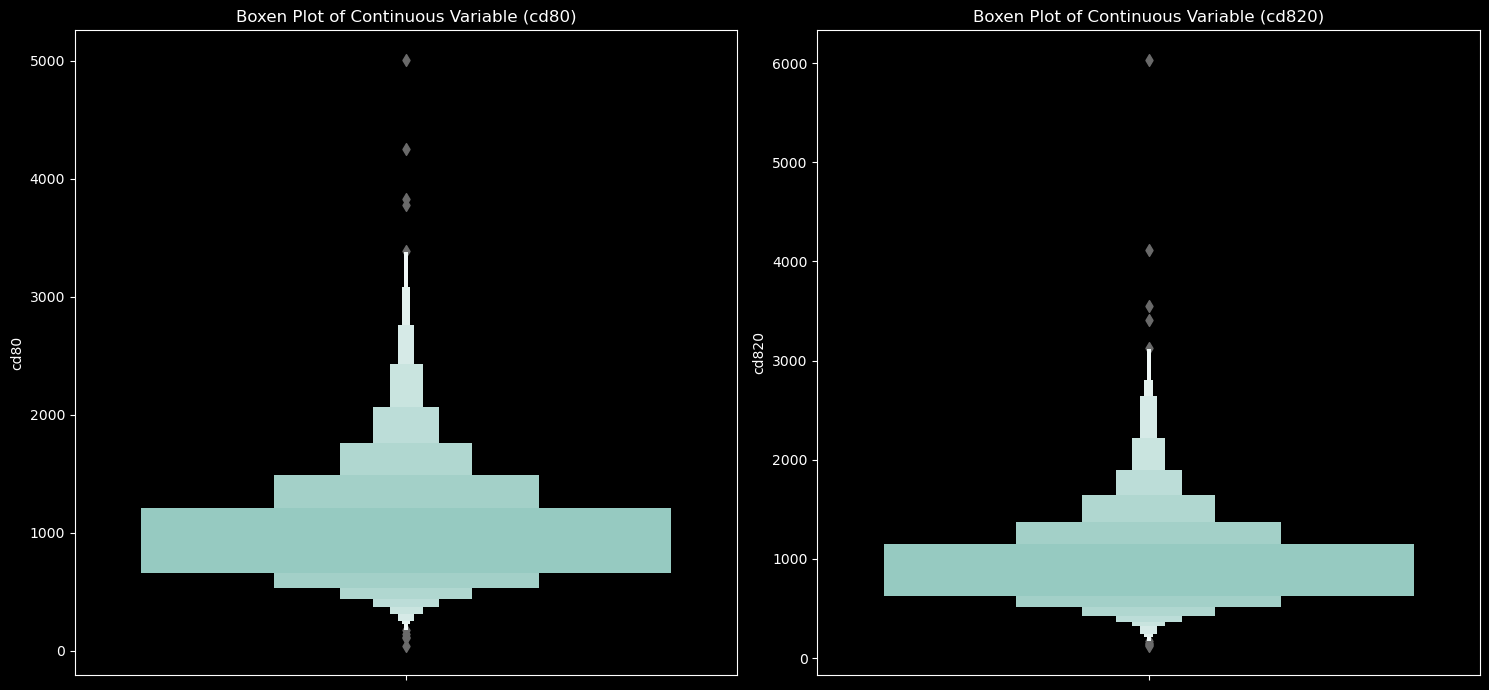

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for i, col in enumerate(['cd80', 'cd820']):
    sns.boxenplot(data=df, y=col, hue=target, linewidth=0, ax=axes[i])
    axes[i].set_title(f'Boxen Plot of Continuous Variable ({col})')
    
plt.tight_layout()
plt.show()

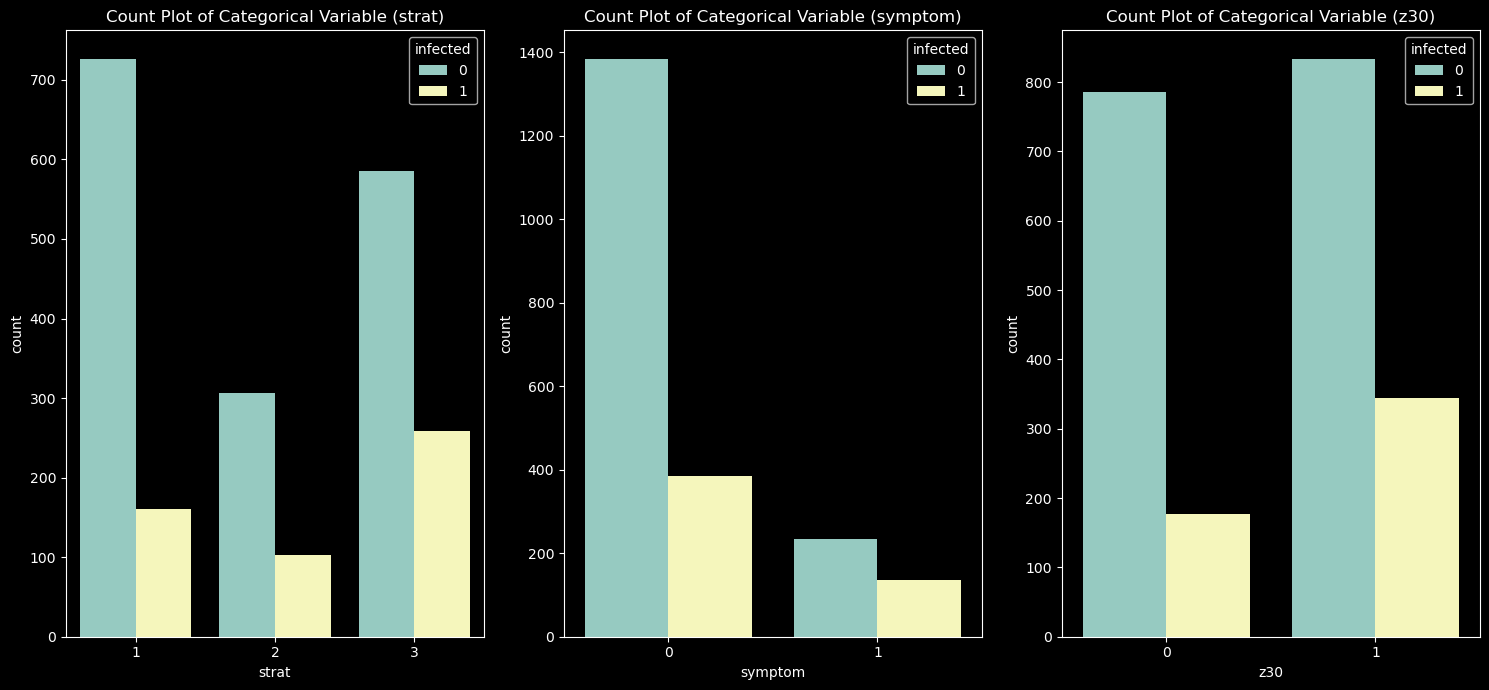

In [75]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))

for i, col in enumerate(['strat', 'symptom','z30']):
    sns.countplot(data=df, x=col, hue=target, linewidth=0, ax=axes[i])
    axes[i].set_title(f'Count Plot of Categorical Variable ({col})')
    
plt.tight_layout()
plt.show()

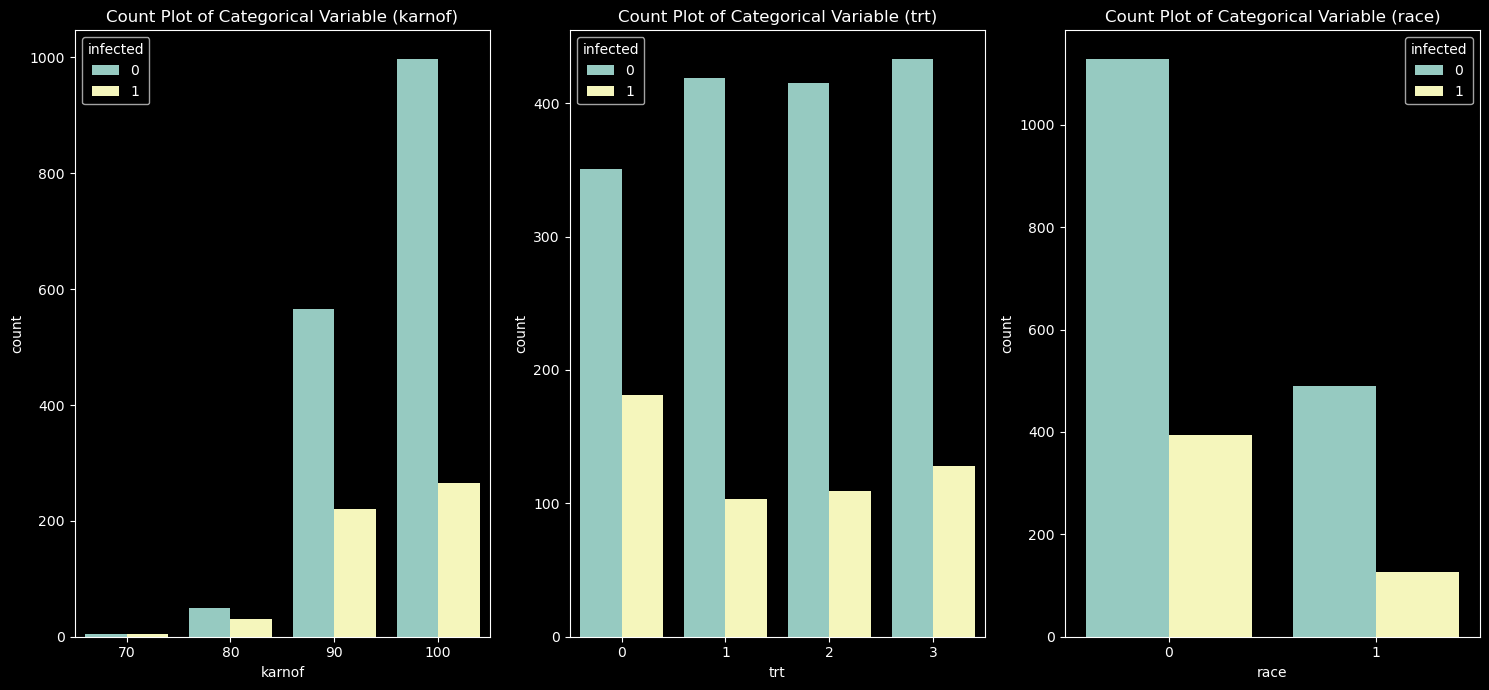

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))

for i, col in enumerate(['karnof', 'trt','race']):
    sns.countplot(data=df, x=col, hue=target, linewidth=0, ax=axes[i])
    axes[i].set_title(f'Count Plot of Categorical Variable ({col})')
    
plt.tight_layout()
plt.show()

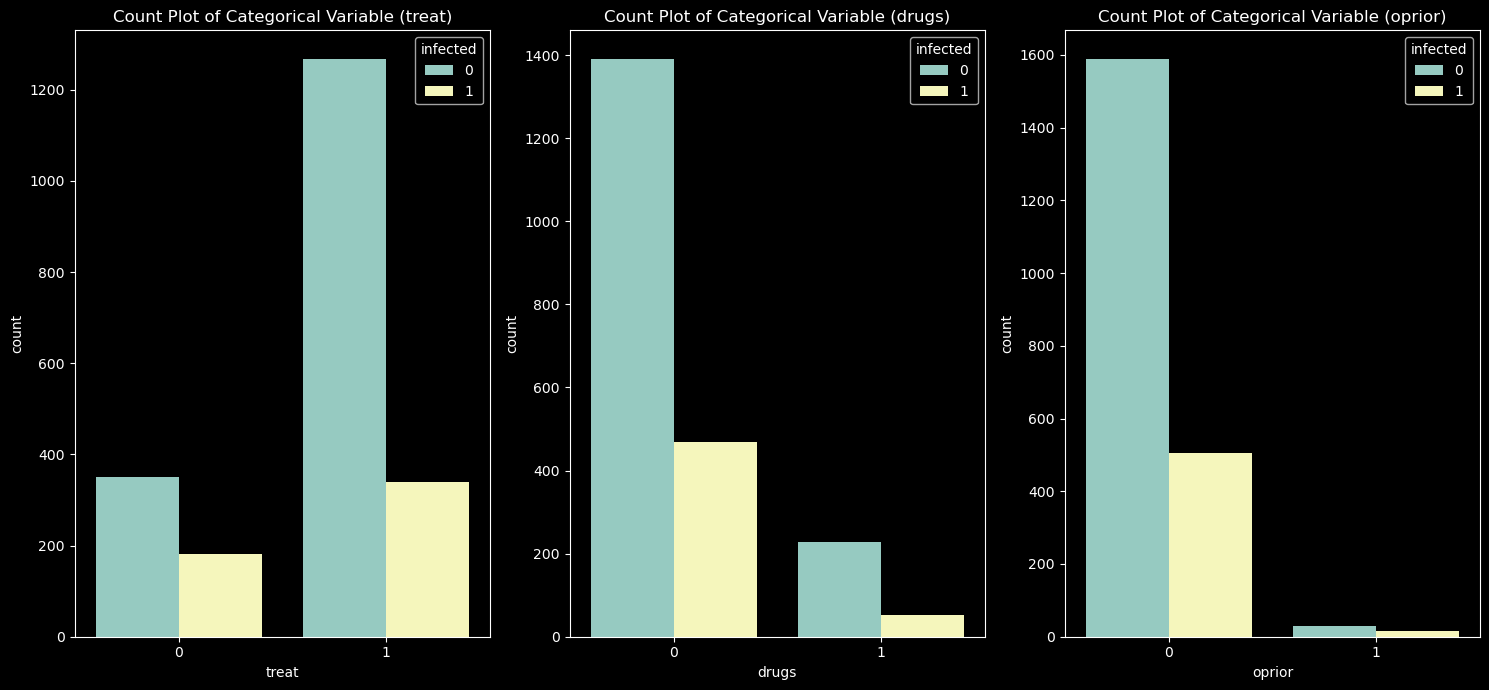

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))

for i, col in enumerate(['treat', 'drugs','oprior']):
    sns.countplot(data=df, x=col, hue=target, linewidth=0, ax=axes[i])
    axes[i].set_title(f'Count Plot of Categorical Variable ({col})')
    
plt.tight_layout()
plt.show()

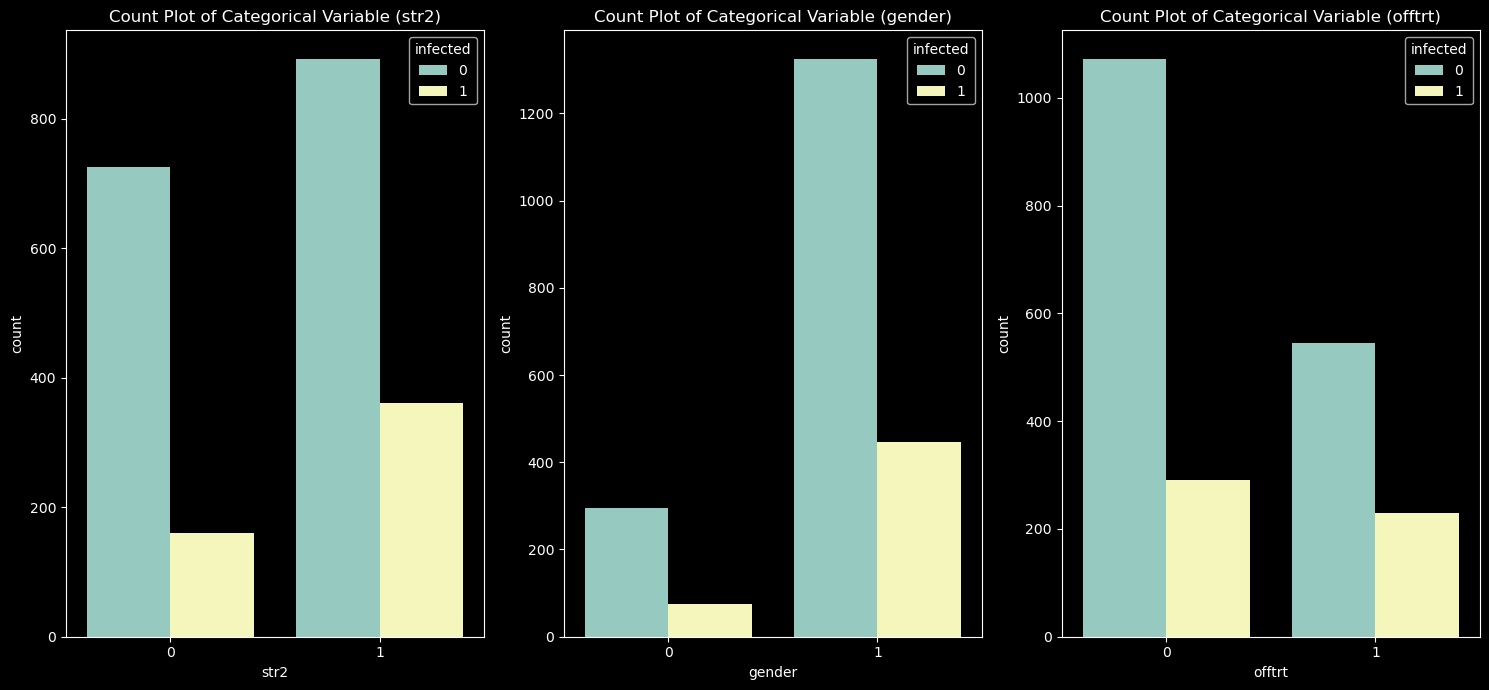

In [78]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))

for i, col in enumerate(['str2', 'gender','offtrt']):
    sns.countplot(data=df, x=col, hue=target, linewidth=0, ax=axes[i])
    axes[i].set_title(f'Count Plot of Categorical Variable ({col})')
    
plt.tight_layout()
plt.show()

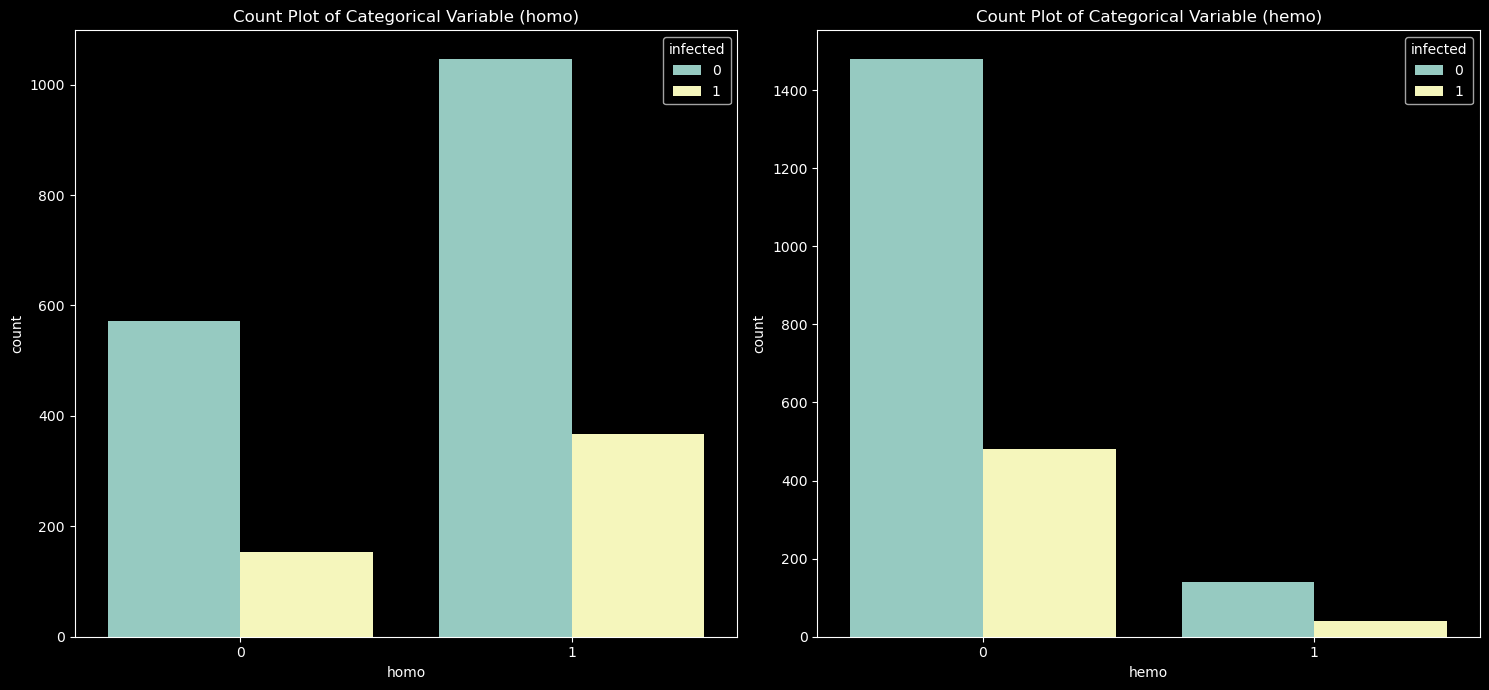

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for i, col in enumerate(['homo', 'hemo']):
    sns.countplot(data=df, x=col, hue=target, linewidth=0, ax=axes[i])
    axes[i].set_title(f'Count Plot of Categorical Variable ({col})')
    
plt.tight_layout()
plt.show()

In [86]:
ax = px.scatter_3d(df, x="age", y="wtkg", z="time", template= "plotly_dark", color="infected")

ax.show()

In [87]:
ax = px.scatter_3d(df, x="preanti", y="cd40", z="cd420", template= "plotly_dark", color="infected")

ax.show()

In [64]:
ax = px.scatter_3d(df, x="preanti", y="cd80", z="cd820", template= "plotly_dark", color="infected")

ax.show()

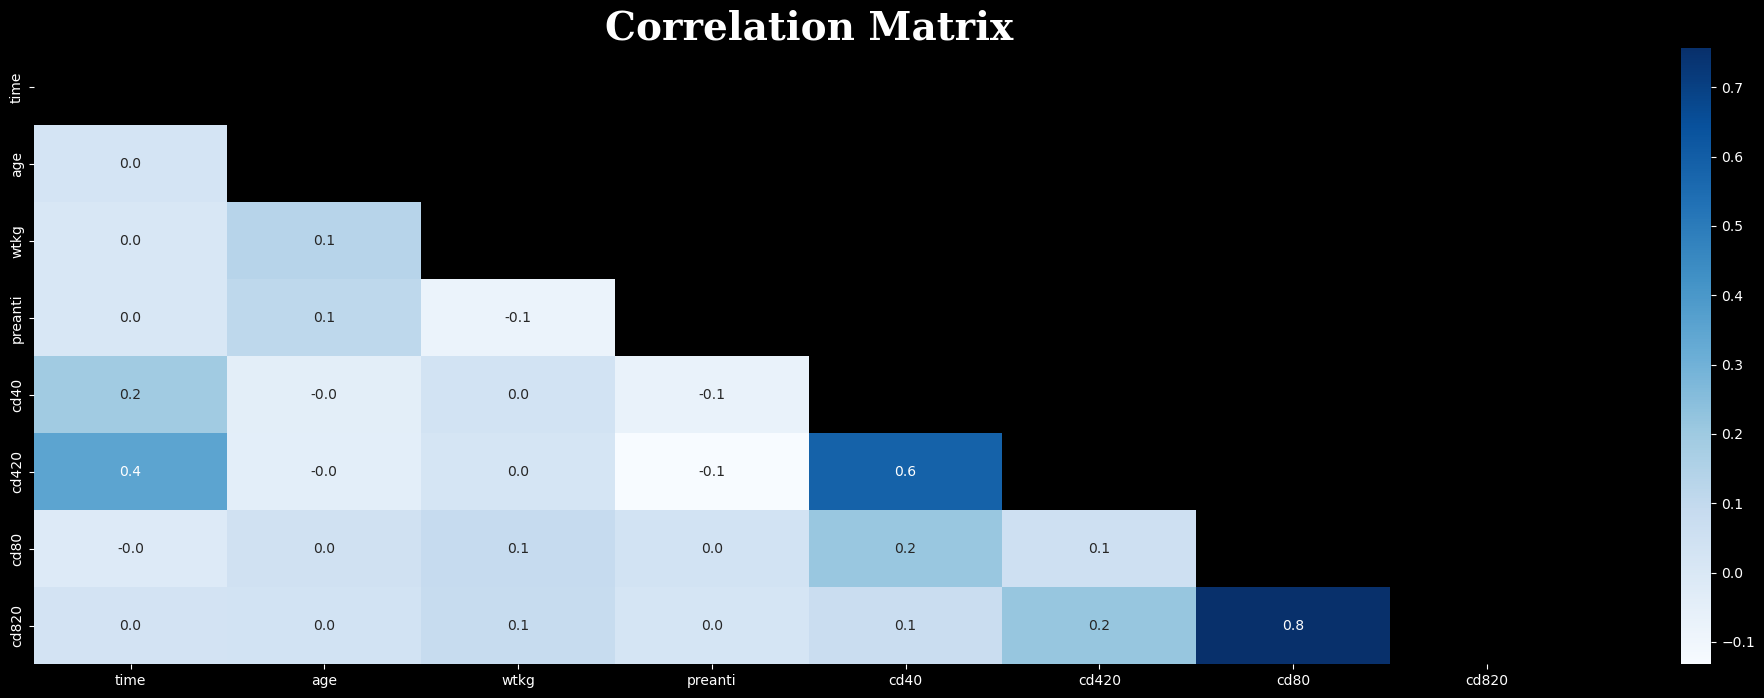

In [66]:
fig = plt.figure(figsize=(25, 8))

gs = fig.add_gridspec(1, 1)

gs.update(wspace=0.3, hspace=0.15)

ax = fig.add_subplot(gs[0, 0])

ax.set_title("Correlation Matrix", fontsize=28, fontweight='bold', fontfamily='serif', color="#fff")

sns.heatmap(df[cont_cols].corr().transpose(), mask=np.triu(np.ones_like(df[cont_cols].corr().transpose())), fmt=".1f", annot=True, cmap='Blues')

plt.show()

In [68]:
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:, -1], random_state=3, train_size=.7)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1497, 22), (1497,), (642, 22), (642,))

In [69]:
smote = SMOTE(random_state = 14)

x_train, y_train = smote.fit_resample(x_train, y_train)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2246, 22), (2246,), (642, 22), (642,))

In [70]:
x_train = MinMaxScaler().fit_transform(x_train)
x_test = MinMaxScaler().fit_transform(x_test)

In [71]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'depth': trial.suggest_int('depth', 1, 12),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'thread_count': -1,
        'loss_function': 'MultiClass',
        'eval_metric': 'Accuracy',
        'verbose': False
    }
    
    model = CatBoostClassifier(**params)
    
    model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=False, early_stopping_rounds=20)
    
    y_pred = model.predict(x_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2024-05-01 10:54:34,151] A new study created in memory with name: no-name-c555c85b-1e7f-475d-a36c-33d0f0ccfedd


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-05-01 10:54:34,977] Trial 0 finished with value: 0.9003115264797508 and parameters: {'iterations': 258, 'learning_rate': 0.39674217352904095, 'depth': 7, 'l2_leaf_reg': 3.7543087240655275, 'border_count': 54}. Best is trial 0 with value: 0.9003115264797508.
[I 2024-05-01 10:54:35,280] Trial 1 finished with value: 0.8894080996884736 and parameters: {'iterations': 561, 'learning_rate': 0.2918594929079495, 'depth': 1, 'l2_leaf_reg': 0.0029020998715954555, 'border_count': 94}. Best is trial 0 with value: 0.9003115264797508.
[I 2024-05-01 10:54:35,643] Trial 2 finished with value: 0.8551401869158879 and parameters: {'iterations': 342, 'learning_rate': 0.015217497164525497, 'depth': 3, 'l2_leaf_reg': 1.346814255060593, 'border_count': 136}. Best is trial 0 with value: 0.9003115264797508.
[I 2024-05-01 10:54:35,769] Trial 3 finished with value: 0.8115264797507789 and parameters: {'iterations': 454, 'learning_rate': 0.014975274513821206, 'depth': 2, 'l2_leaf_reg': 0.6659240732105718, '

[I 2024-05-01 10:56:03,749] Trial 31 finished with value: 0.8987538940809969 and parameters: {'iterations': 121, 'learning_rate': 0.12884628799491496, 'depth': 10, 'l2_leaf_reg': 0.006671166835986901, 'border_count': 92}. Best is trial 7 with value: 0.9080996884735203.
[I 2024-05-01 10:56:07,822] Trial 32 finished with value: 0.8909657320872274 and parameters: {'iterations': 156, 'learning_rate': 0.3002825831960878, 'depth': 11, 'l2_leaf_reg': 0.0022068444009737368, 'border_count': 82}. Best is trial 7 with value: 0.9080996884735203.
[I 2024-05-01 10:56:09,179] Trial 33 finished with value: 0.9065420560747663 and parameters: {'iterations': 211, 'learning_rate': 0.10060899579669355, 'depth': 8, 'l2_leaf_reg': 0.009596608045403108, 'border_count': 108}. Best is trial 7 with value: 0.9080996884735203.
[I 2024-05-01 10:56:11,213] Trial 34 finished with value: 0.9049844236760125 and parameters: {'iterations': 212, 'learning_rate': 0.07283845408249781, 'depth': 8, 'l2_leaf_reg': 0.0094624634

In [72]:
model = CatBoostClassifier(
    verbose=0, 
    random_state=3,
    **study.best_params
)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [73]:
print (classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       504
           1       0.75      0.80      0.77       138

    accuracy                           0.90       642
   macro avg       0.85      0.86      0.85       642
weighted avg       0.90      0.90      0.90       642



<Axes: >

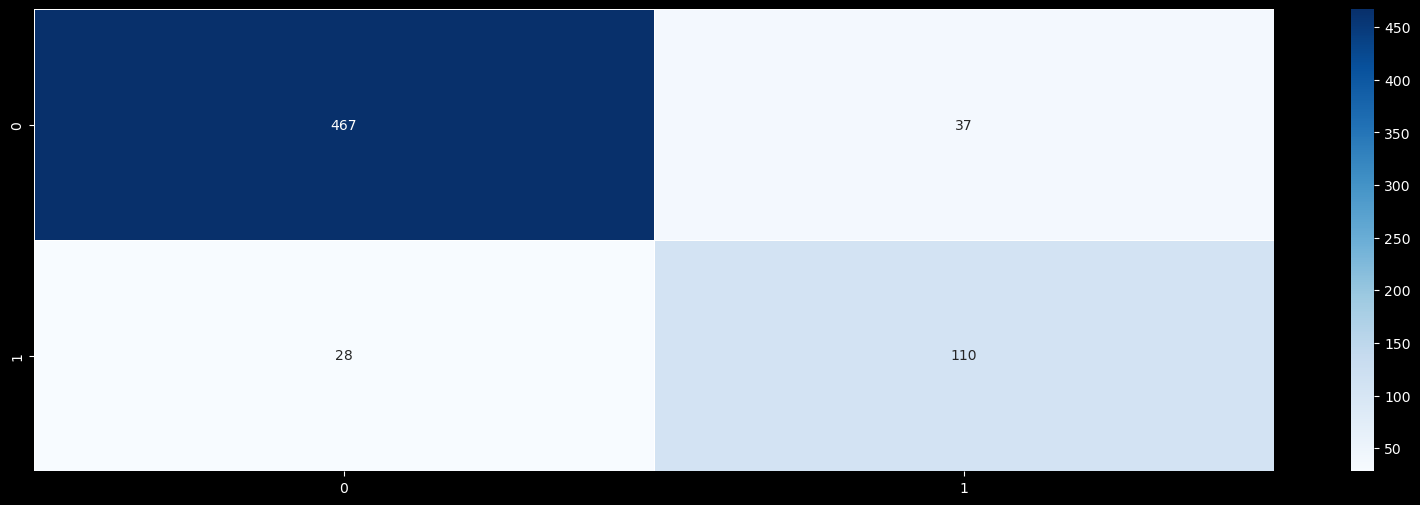

In [74]:
plt.subplots(figsize=(20, 6))

sns.heatmap(confusion_matrix(y_pred, y_test), annot = True, fmt="d", cmap="Blues", linewidths=.5)